In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_absolute_percentage_error

In [21]:
# Load the dataset
data = pd.read_csv('tea_production.csv')
data['Year-Month'] = pd.to_datetime(data['Year-Month'])
data.set_index('Year-Month', inplace=True)

In [22]:
data.head()

,High_Grown_Production_(Kg),Mid_Grown_Production_(Kg),Low_Grown_Production_(Kg),National_Production_(Kg),FEE_(USD)
Year-Month,,,,,
2012-01-01,5361185.05,3652353.15,14348315.90,23361854.10,9.532390e+07
2012-02-01,5538399.31,3955745.75,13133213.00,22627358.06,1.001710e+08
2012-03-01,6385525.09,4625138.90,17929328.00,28939991.99,1.303051e+08
2012-04-01,7323011.00,5748401.20,16982493.50,30053905.70,1.104128e+08
2012-05-01,8726319.70,5898297.10,18086627.25,32711244.05,1.491855e+08


In [23]:
# ADF Test
def adf_test(series):
    result = adfuller(series)
    return result[1]  # Return p-value

In [24]:
adf_test(data["FEE_(USD)"][12:])

0.1512564106569405

In [25]:
adf_test(data["National_Production_(Kg)"][12:])

0.6502238435542471

In [47]:
# Apply Box-Cox Transformation
data['Production_Boxcox'], prod_lambda = boxcox(data['National_Production_(Kg)'])
data['Forex_Boxcox'], forex_lambda = boxcox(data['FEE_(USD)'])

In [48]:
# Differencing 1
data['Production_diff'] = data['Production_Boxcox'].diff().dropna()
data['Forex_diff'] = data['Forex_Boxcox'].diff().dropna()
data.dropna(inplace=True)

In [49]:
adf_test(data["FEE_(USD)"][12:])

0.04741696110567088

In [50]:
adf_test(data["National_Production_(Kg)"][12:])

0.5253937284978999

In [51]:
# Train-test split
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [52]:
# ARIMA Model for Production
prod_model = ARIMA(train['Production_Boxcox'], order=(1,1,1)).fit()
prod_forecast = prod_model.forecast(steps=len(test))
prod_forecast = inv_boxcox(prod_forecast, prod_lambda)

C:\Users\hasit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hasit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hasit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hasit\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hasit\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA param

In [53]:
# ARIMAX Model for Forex (Using Production as Exogenous Variable)
forex_model = ARIMA(train['Forex_Boxcox'], order=(1,1,1), exog=train['Production_Boxcox']).fit()
forex_forecast = forex_model.forecast(steps=len(test), exog=test['Production_Boxcox'])
forex_forecast = inv_boxcox(forex_forecast, forex_lambda)

C:\Users\hasit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hasit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hasit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [54]:
# MAPE Calculation
prod_mape = mean_absolute_percentage_error(test['National_Production_(Kg)'], prod_forecast)
forex_mape = mean_absolute_percentage_error(test['FEE_(USD)'], forex_forecast)
print(f'Production Forecast MAPE: {prod_mape:.2%}')
print(f'Forex Forecast MAPE: {forex_mape:.2%}')

Production Forecast MAPE: 20.08%
Forex Forecast MAPE: 9.05%


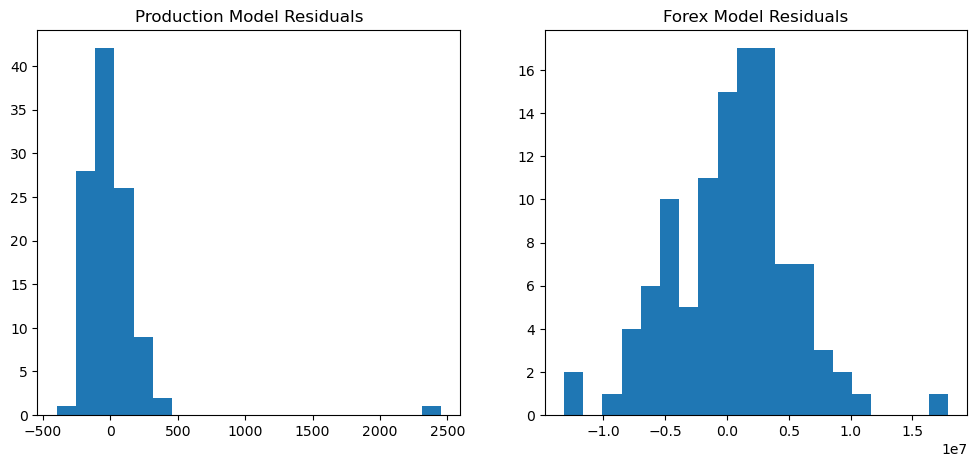

In [55]:
# Residual Analysis
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(prod_model.resid, bins=20)
plt.title("Production Model Residuals")
plt.subplot(1,2,2)
plt.hist(forex_model.resid, bins=20)
plt.title("Forex Model Residuals")
plt.show()

In [59]:
# Forecasting for Next 60 Months
future_index = pd.date_range(start=data.index[-1], periods=61, freq='M')[1:]
future_prod_forecast = prod_model.forecast(steps=60)
future_prod_forecast = inv_boxcox(future_prod_forecast, prod_lambda)
future_forex_forecast = forex_model.forecast(steps=60, exog=future_prod_forecast)
future_forex_forecast = inv_boxcox(future_forex_forecast, forex_lambda)

C:\Users\hasit\AppData\Local\Temp\ipykernel_13500\353772656.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=data.index[-1], periods=61, freq='M')[1:]


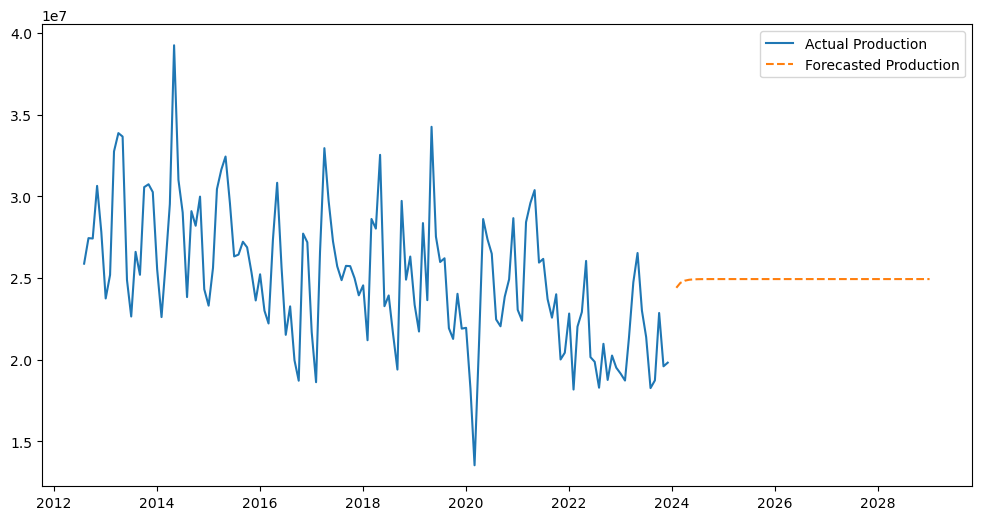

In [60]:
# Plot Results
plt.figure(figsize=(12,6))
plt.plot(data.index, data['National_Production_(Kg)'], label='Actual Production')
plt.plot(future_index, future_prod_forecast, label='Forecasted Production', linestyle='dashed')
plt.legend()
plt.show()

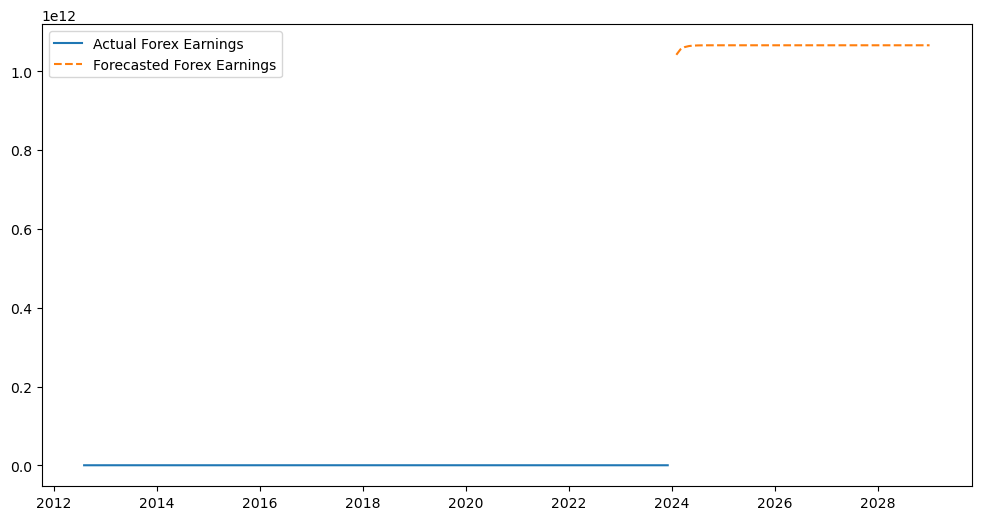

In [61]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data['FEE_(USD)'], label='Actual Forex Earnings')
plt.plot(future_index, future_forex_forecast, label='Forecasted Forex Earnings', linestyle='dashed')
plt.legend()
plt.show()

In [62]:
# Create a DataFrame for Monthly Forecast Analysis
forecast_table = pd.DataFrame({
    'Date': future_index,
    'Forecasted_Production': future_prod_forecast,
    'Forecasted_Forex_Earnings': future_forex_forecast
})

In [63]:
# Save the table to CSV
forecast_table.to_csv('forecasted_values.csv', index=False)

In [67]:
# Print the first few rows of the forecast table
forecast_table.head()

,Date,Forecasted_Production,Forecasted_Forex_Earnings
2021-09-01,2024-01-31,2.439452e+07,1.041873e+12
2021-10-01,2024-02-29,2.469728e+07,1.055594e+12
2021-11-01,2024-03-31,2.482835e+07,1.061537e+12
2021-12-01,2024-04-30,2.488493e+07,1.064103e+12
2022-01-01,2024-05-31,2.490932e+07,1.065210e+12
